## Planejamento dos diversos Vendors (utilizando LLM)

In [16]:
import openai
openai.__version__

import os
from openai import AzureOpenAI
from configparser import ConfigParser, ExtendedInterpolation
import httpx
import numpy as np
import pandas as pd
import PyPDF2
from datetime import datetime

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('config-v1.x.ini', 'UTF-8')

http_client = httpx.Client(verify='petrobras-ca-root.pem')

client = AzureOpenAI(
    api_key=config['TST']['API_KEY_MODELOS_TEXTO'],
    api_version=config['OPENAI']['OPENAI_API_VERSION'],
    azure_endpoint=config['TST']['LITELLM_BASE_URL'],
    http_client=http_client
)

In [17]:
# Uso
caminho_base = r'C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\files'
pasta_resumos = r'C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\resumos'
file_path = r'C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\avanco.xlsx'
# Carrega o DataFrame do Excel C:\Users\elxy\Documents\Codigos\Python\P84_85\planning\data_Supply Scope_Erection (3RW vs 2RW).xlsx
file_path_supply = r'C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\data_Supply Scope_Erection (3RW vs 2RW).xlsx'
file_path_pkg_supply = r'C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\data_Packages.xlsx'


### Carrega Dados Básicos

In [18]:
# Set the correct path to the Excel file
excel_filename = 'C:/Users/ELXY/Documents/Codigos/Python/P84_85/DadosBasicos/dados_basicos.xlsx'

# Read the Excel file
df_db = pd.read_excel(excel_filename, sheet_name=0)  # sheet_name=0 reads the first sheet
df_db = df_db.fillna('')
# display(df_db)

In [19]:
# Consulta API para listar modelos
models_resp = http_client.get(config['TST']['LITELLM_BASE_URL'] + '/models', headers={
    'api-key': config['TST']['API_KEY_MODELOS_TEXTO'],
    'Authorization': 'Bearer ' + config['TST']['API_KEY_MODELOS_TEXTO']
})
models_resp.raise_for_status()

<Response [200 OK]>

In [20]:
all_models = [m['id'] for m in models_resp.json()['data']]
len(all_models)

46

In [21]:
# Modelos de chat
models_chat = sorted(m for m in all_models if 'embedding' not in m)
models_chat

['claude-3-5-haiku-20241022-v1',
 'claude-3-7-sonnet-20250219',
 'claude-instant-v1',
 'claude-v2',
 'claude-v2.1',
 'claude-v3-haiku',
 'claude-v3-sonnet',
 'claude-v35-sonnet',
 'claude-v35-sonnet-v2',
 'command-light-v14',
 'command-r',
 'command-r-plus',
 'command-v14',
 'dall-e-3',
 'deepseek-r1-v1',
 'gpt-35-turbo-16k',
 'gpt-4o',
 'gpt-4o-2024-08-06',
 'gpt-4o-mini',
 'llama3-1-405b-instruct-v1',
 'llama3-1-70b-instruct-v1',
 'llama3-1-8b-instruct-v1',
 'llama3-2-11b-instruct-v1',
 'llama3-2-1b-instruct-v1',
 'llama3-2-3b-instruct-v1',
 'llama3-2-90b-instruct-v1',
 'llama3-3-70b-instruct-v1',
 'llama3-70b-instruct',
 'llama3-8b-instruct',
 'mistral-7b-instruct',
 'mistral-large',
 'mistral-small',
 'mixtral-8x7b-instruct',
 'nova-lite-v1',
 'nova-micro-v1',
 'nova-pro-v1',
 'o3',
 'o4-mini',
 'stable-diffusion-xl-v1']

In [22]:
# Defining a function to send the prompt to the ChatGPT model
# More info : https://learn.microsoft.com/en-us/azure/cognitive-services/openai/how-to/chatgpt?pivots=programming-language-chat-completions
def send_message(messages, engine, max_response_tokens=500):
    response = client.chat.completions.create(
        model=engine,
        messages=messages,
        # temperature=0.5,
        max_tokens=max_response_tokens,
        # top_p=0.9,
    )
    return response.choices[0].message.content


# Defining a function to print out the conversation in a readable format
def print_conversation(messages):
    for message in messages:
        print(f"[{message['role'].upper()}]")
        print(message['content'])
        print()

### Extrair texto do PDF

In [23]:
def extrair_texto_pdf(caminho_pdf):
    """Extrai texto de um arquivo PDF"""
    with open(caminho_pdf, 'rb') as arquivo:
        leitor_pdf = PyPDF2.PdfReader(arquivo)
        texto_total = ''
        
        # Iterando sobre cada página do PDF
        for pagina in leitor_pdf.pages:
            texto_pagina = pagina.extract_text()
            texto_total += texto_pagina + '\n'
        
        return texto_total.strip()
    


In [24]:
def analisar_documento(user_message):
    """Analisa o documento PDF e retorna o texto extraído""" 
    base_system_message = "Você é um assistente especializado em planejamento de suprimentos para grande projetos de construção de plataformas de petróleo. Você é capaz de responder perguntas sobre cronogramas e suprimentos, sobre os projetos e sobre os fornecedores."
    base_system_message += " Você também é capaz de realizar resumos sobre o cronograma e status de vários pacotes de equipamentos."
    base_system_message += " Peço realizar um resumo das datas planejadas Inicio e Fim dos diversos TAGs de equipamentos que aparece detalhado de cada pacote."
    base_system_message += " Os TAGs dos equipamentos seguem o seguinte padrão, por exemplo: 'B-1251001A', 'M-B-5412001A/B', 'LR-1231001', 'TN-5266001' etc."
    base_system_message += " Para cada linha do resumo colocar um equipamento com suas informações (datas planejadas Start e Finish e Percentage of Completion)."
    base_system_message += " Limitar-se somente a responder o que foi perguntado, sem adicionar informações extras. Não repetir as informações já fornecidas no resumo."
    base_system_message += " Observar que em alguns casos o pacote tem apenas um TAG e neste caso o cronograma diz respeito a somente este TAG. Neste caso colocar somente um TAG no resumo."
    base_system_message += " O resumo deve ser feito em formato de tabela, com as colunas: TAG, Start, Finish e Percentage of Completion."
    base_system_message += " Por exemplo, o resumo deve ser algo como: \n"
    base_system_message += " | TAG | Start | Finish | Percentage of Completion |\n"
    base_system_message += " | B-1251001A | 2023-01-01 | 2023-12-31 | 75% |\n"
    base_system_message += " | GD-5266501 | 2025-03-04 | 2027-09-07 | 1.26% |\n"
    base_system_message += " Lembre-se de que o resumo deve ser claro e conciso, sem informações desnecessárias."
    base_system_message += " Colocar ao final de cada arquivo o texto 'Fim do resumo'."
    base_system_message += " Não incluir no arquivo texto informações do tipo |---|---|---|---| para demarcar o cabeçalho."
    system_message = base_system_message.strip()

    # Verifica se o texto de entrada está vazio
    if not user_message or len(user_message.strip()) == 0:
        print("Texto de entrada está vazio.")
        return None

    # Create the list of messages
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]

    max_response_tokens = 500
    model = 'claude-v35-sonnet-v2'
    print(model.upper())

    try:
        # Inicializa response antes da chamada
        response = None
        
        response = send_message(
            messages,
            engine=model,
            max_response_tokens=max_response_tokens
        )
        
        # Verifica se a resposta não é None
        if response:
            return response
        else:
            print("Não foi possível gerar resumo.")
            return None

    except Exception as e:
        print(f"Erro ao processar documento: {e}")
        print('-' * 30)
        # Retorna None em caso de exceção
        return None


In [25]:
def processar_pacotes(df_db, caminho_base):
    # Dicionário para armazenar textos dos PDFs
    textos_pdfs = {}

    # Iterar sobre os pacotes no dataframe
    for pacote in df_db['PKG_DESCRIPTION']:
        # Caminho completo da pasta do pacote
        caminho_pacote = os.path.join(caminho_base, pacote)

        # Verificar se a pasta existe
        if os.path.exists(caminho_pacote) and os.path.isdir(caminho_pacote):
            # String para armazenar texto consolidado dos PDFs deste pacote
            texto_consolidado_pacote = ""

            # Iterar sobre arquivos na pasta do pacote
            for arquivo in os.listdir(caminho_pacote):
                # Verificar se é um arquivo PDF
                if arquivo.lower().endswith('.pdf'):
                    caminho_completo_pdf = os.path.join(caminho_pacote, arquivo)
                    print(f"Lendo arquivo: {caminho_completo_pdf}")

                    try:
                        texto_pdf = extrair_texto_pdf(caminho_completo_pdf)
                        # Adiciona o texto do PDF ao texto consolidado, 
                        # com uma linha em branco entre os documentos
                        texto_consolidado_pacote += texto_pdf + "\n\n"
                    except Exception as e:
                        print(f"Erro ao processar {caminho_completo_pdf}: {e}")

            # Remove espaços em branco extras no início e no fim
            texto_consolidado_pacote = texto_consolidado_pacote.strip()

            # Armazena o texto consolidado no dicionário
            textos_pdfs[pacote] = texto_consolidado_pacote

    return textos_pdfs


In [26]:
# Processar pacotes:
textos_extraidos = processar_pacotes(df_db, caminho_base)

# Analisar os textos extraídos
for pacote, texto in textos_extraidos.items():
    print("-" * 80)
    print(f"Processando Pacote: {pacote}")
    
    # Verifica se o texto não está vazio
    if not texto or len(texto.strip()) == 0:
        print(f"Texto do pacote {pacote} está vazio. Pulando.")
        continue
    
    resumo = analisar_documento(texto)
    
    if resumo is None:
        print(f"Não foi possível gerar resumo para o pacote {pacote}")
        continue

    print(f"Resumo realizado com sucesso. Tamanho: {len(resumo)} caracteres")
    
    # Salvar resumo em arquivo de texto
    nome_arquivo_resumo = f"{pacote.replace('/', '_').replace('\\', '_')}_resumo.txt"
    caminho_resumo = os.path.join(pasta_resumos, nome_arquivo_resumo)
    
    try:
        with open(caminho_resumo, "w", encoding="utf-8") as f:
            f.write(f"RESUMO DO RELATÓRIO: {pacote}\n")
            f.write("=" * 80 + "\n\n")
            f.write(resumo)
        
        print(f"Resumo salvo em: {caminho_resumo}")
    except Exception as e:
        print(f"Erro ao salvar resumo do pacote {pacote}: {e}")

print(f"\nFim do processamento: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Lendo arquivo: C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\files\API 610 CENTRIFUGAL PUMPS\KSB Manufacturing Schedule (OV9975700779-100 B-1223001AB)_02-07-25.pdf
Lendo arquivo: C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\files\API 610 CENTRIFUGAL PUMPS\KSB Manufacturing Schedule (OV9975700779-200 B-1223002AB)_02-07-25.pdf
Lendo arquivo: C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\files\API 610 CENTRIFUGAL PUMPS\KSB Manufacturing Schedule (OV9975700779-400 B-1223004AB)_02-07-25.pdf
Lendo arquivo: C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\files\API 610 CENTRIFUGAL PUMPS\KSB Manufacturing Schedule (OV9975700779-500 B-5124001AD)_02-07-25.pdf
Lendo arquivo: C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\files\API 610 CENTRIFUGAL PUMPS\KSB Manufacturing Schedule (OV9975700779-600 B-5125001AC)_02-07-25.pdf
Lendo arquivo: C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\files\API 610 CENTRIFUGAL PUMPS\KSB Manufacturing Schedule (OV997

### Gera arquivo Excel com base nas informações dos arquivos texto

In [27]:
import os
import re
import pandas as pd
from datetime import datetime

# Caminho para a pasta com os arquivos de resumo
pasta_resumos = r"C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\resumos"

# Lista para armazenar os dados extraídos
dados = []

# Lista todos os arquivos na pasta
arquivos = [f for f in os.listdir(pasta_resumos) if f.endswith('_resumo.txt')]

# Percorre todos os arquivos de resumo na pasta
for arquivo in arquivos:
    # Extrai o nome do pacote do nome do arquivo
    pkg_description = arquivo.replace('_resumo.txt', '')
    # Caminho completo para o arquivo
    caminho_arquivo = os.path.join(pasta_resumos, arquivo)
    try:
        print(f"Processando arquivo: {caminho_arquivo}")
        with open(caminho_arquivo, 'r', encoding='utf-8') as f:
            content = f.read()
            
            # Expressão regular para encontrar tabelas markdown
            tabela_regex = r"\|\s*TAG\s*\|\s*Start\s*\|\s*Finish\s*\|\s*Percentage\s*of\s*Completion\s*\|[\r\n]+([\s\S]*?)(?:Fim do resumo|$)"
            
            match = re.search(tabela_regex, content, re.IGNORECASE)
            if not match:
                print(f"Tabela não encontrada em: {caminho_arquivo}")
                continue
                
            tabela = match.group(1)
            
            # Divide por linhas e remove linhas vazias ou que são apenas delimitadores
            linhas = [linha.strip() for linha in tabela.split('\n') 
                     if linha.strip() and '|' in linha 
                     and not linha.strip().startswith('|---')]
            
            for linha in linhas:
                # Extrai as colunas dividindo a linha pelos caracteres '|'
                colunas = [col.strip() for col in linha.split('|')]
                # Remove elementos vazios (que podem ocorrer no início e no fim)
                colunas = [col for col in colunas if col]
                
                if len(colunas) >= 4: # Deve ter pelo menos 4 colunas
                    dados.append({
                        'TAG': colunas[0],
                        'Start': colunas[1],
                        'Finish': colunas[2],
                        'Percentage of Completion': colunas[3],
                        'PKG_DESCRIPTION': pkg_description
                    })
    except Exception as e:
        print(f"Erro ao processar o arquivo {arquivo}: {e}")

# Cria o DataFrame
df_avanco = pd.DataFrame(dados)

# Função para converter datas em diferentes formatos para YYYY-MM-DD
def converter_data(data_str):
    if pd.isna(data_str) or data_str == '':
        return data_str
    
    # Tratar formato específico DD-MMM-YY (ex: 04-Mar-25)
    pattern = r'(\d{1,2})-([A-Za-z]{3})-(\d{2})'
    match = re.match(pattern, data_str)
    if match:
        dia = match.group(1).zfill(2)
        mes = match.group(2).lower()
        ano = match.group(3)
        
        # Mapear abreviações de meses para números
        meses = {
            'jan': '01', 'feb': '02', 'fev': '02', 'mar': '03',
            'apr': '04', 'abr': '04', 'may': '05', 'mai': '05',
            'jun': '06', 'jul': '07', 'aug': '08', 'ago': '08',
            'sep': '09', 'set': '09', 'oct': '10', 'out': '10',
            'nov': '11', 'dec': '12', 'dez': '12'
        }
        
        if mes.lower() in meses:
            mes_num = meses[mes.lower()]
            # Converter ano de 2 dígitos para 4 dígitos
            # Assumir que anos 00-29 são 2000-2029, anos 30-99 são 1930-1999
            ano_completo = '20' + ano if int(ano) < 30 else '19' + ano
            return f"{ano_completo}-{mes_num}-{dia}"
    
    # Tenta diferentes formatos de data
    formatos = [
        '%d/%m/%Y',  # DD/MM/YYYY
        '%d-%m-%Y',  # DD-MM-YYYY
        '%Y/%m/%d',  # YYYY/MM/DD
        '%Y-%m-%d',  # YYYY-MM-DD
        '%d/%m/%y',  # DD/MM/YY
        '%d-%m-%y',  # DD-MM-YY
        '%m/%d/%Y',  # MM/DD/YYYY (formato americano)
        '%m-%d-%Y',  # MM-DD-YYYY (formato americano)
        '%b %d, %Y', # MMM DD, YYYY (ex: Jan 01, 2023)
        '%d %b %Y',  # DD MMM YYYY (ex: 01 Jan 2023)
        '%d %b %y'   # DD MMM YY (ex: 01 Jan 23)
    ]
    
    for formato in formatos:
        try:
            data = datetime.strptime(data_str, formato)
            return data.strftime('%Y-%m-%d')
        except ValueError:
            continue
    
    # Se nenhum formato funcionar, retorna a string original
    print(f"Aviso: Não foi possível converter a data '{data_str}' para o formato YYYY-MM-DD")
    return data_str

# Aplica a função de conversão às colunas de data
df_avanco['Start'] = df_avanco['Start'].apply(converter_data)
df_avanco['Finish'] = df_avanco['Finish'].apply(converter_data)

# Salva no Excel
df_avanco.to_excel(file_path, sheet_name="avanco_ia", index=False)

print(f"Arquivo Excel salvo em: {file_path}")
print(f"Total de registros processados: {len(dados)}")


Processando arquivo: C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\resumos\API 610 CENTRIFUGAL PUMPS_resumo.txt
Processando arquivo: C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\resumos\FRESH WATER CHLORINATION UNIT_resumo.txt
Processando arquivo: C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\resumos\FRESH WATER MAKER FOR OIL DILUTION_resumo.txt
Processando arquivo: C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\resumos\NITROGEN GENERATOR UNITS_resumo.txt
Processando arquivo: C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\resumos\NON-API 610 CENTRIFUGAL PUMPS_resumo.txt
Processando arquivo: C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\resumos\OFFSHORE CRANE_resumo.txt
Processando arquivo: C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\resumos\PIG LAUNCHERS AND RECEIVERS_resumo.txt
Processando arquivo: C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\resumos\PROGRESSIVE CAVITY PUMPS_resumo.txt
Processando arquivo: C:\Us

### TAGs individualizados

In [28]:
import pandas as pd
import re
import os
from pathlib import Path

def expand_tag(tag):
    """
    Função para expandir TAGs compostos em TAGs individuais,
    incluindo casos com múltiplos separadores como A/B/C
    """
    # Remove espaços extras no TAG
    tag = tag.strip()
    
    # Verifica se há um padrão de letras separadas por barras (A/B, A/B/C, etc.)
    # Primeiro, remova todos os espaços para facilitar o processamento
    tag_no_spaces = tag.replace(" ", "")
    
    # Procura por padrões como A/B, A/C, A/B/C, etc.
    pattern = r'(.*?)([A-Z])(/[A-Z])+(?:-(\d+))?$'
    match = re.search(pattern, tag_no_spaces)
    
    if match:
        # Encontra a base do TAG (parte antes das letras)
        base_part_match = re.search(r'(.*[^A-Z])([A-Z])(/[A-Z])+(?:-(\d+))?$', tag_no_spaces)
        if base_part_match:
            base = base_part_match.group(1)
        else:
            # Caso não consiga separar corretamente, usa uma abordagem mais simples
            parts = re.split(r'[A-Z](/[A-Z])+', tag_no_spaces, 1)
            base = parts[0]
        
        # Encontra o sufixo (parte após as letras, como -01)
        suffix_match = re.search(r'.*(/[A-Z])+(-\d+)?$', tag_no_spaces)
        suffix = suffix_match.group(2) if suffix_match and suffix_match.group(2) else ""
        
        # Encontra todas as letras separadas por barras
        letters_part = re.search(r'([A-Z](/[A-Z])+)(?:-\d+)?$', tag_no_spaces).group(1)
        letters = [letter for letter in letters_part.split('/') if letter]
        
        # Se temos apenas uma letra, é porque a regex pegou a primeira letra separadamente
        if len(letters) == 1:
            # Tenta uma abordagem diferente
            letters_match = re.findall(r'[A-Z]', letters_part)
            if letters_match:
                letters = letters_match
        
        # Para casos como A/C, precisamos gerar B também
        if len(letters) == 2 and ord(letters[1]) - ord(letters[0]) > 1:
            start_char = letters[0]
            end_char = letters[1]
            letters = [chr(i) for i in range(ord(start_char), ord(end_char) + 1)]
        
        # Reconstrói os TAGs individuais
        return [f"{base}{letter}{suffix}" for letter in letters]
    
    # Abordagem alternativa para casos mais complexos
    # Procura por padrões como "A/B/C" em qualquer parte do TAG
    parts = re.split(r'([A-Z](/[A-Z])+)', tag, 1)
    
    if len(parts) > 1:
        base_part = parts[0].strip()
        letters_part = parts[1]
        suffix_part = parts[2].strip() if len(parts) > 2 else ""
        
        # Extrai as letras do padrão A/B/C
        letters = re.findall(r'[A-Z]', letters_part)
        
        # Verifica se é um padrão de intervalo (A/C) ou lista específica (A/B/C)
        if len(letters) == 2:
            # Intervalo de letras
            start_char = letters[0]
            end_char = letters[1]
            letters = [chr(i) for i in range(ord(start_char), ord(end_char) + 1)]
        
        # Reconstrói os TAGs individuais
        return [f"{base_part}{letter}{suffix_part}" for letter in letters]
    
    # Se não encontrou padrão de composição, retorna o TAG original
    return [tag]

def process_excel_file(file_path):
    """
    Processa o arquivo Excel, expandindo os TAGs compostos
    """
    try:
        # Lê o arquivo Excel
        df = pd.read_excel(file_path, sheet_name="avanco_ia")
        
        # Cria um novo DataFrame para armazenar os resultados
        result_df = pd.DataFrame(columns=df.columns)
        
        # Processa cada linha
        for index, row in df.iterrows():
            tag = str(row['TAG'])
            
            # Implementação alternativa mais robusta para lidar com casos complexos
            individual_tags = []
            
            # Verifica se o TAG contém barras (/)
            if '/' in tag:
                # Remove espaços extras e consolida espaços
                tag_clean = re.sub(r'\s+', ' ', tag.strip())
                
                # Identifica a parte antes das letras com barras
                match = re.search(r'(.*?)([A-Z])/([A-Z])', tag_clean)
                if match:
                    prefix = match.group(1)
                    start_letter = match.group(2)
                    end_letter = match.group(3)
                    
                    # Verifica se há mais letras após a barra
                    remaining = tag_clean[match.end():]
                    more_letters = re.findall(r'/([A-Z])', remaining)
                    
                    # Se encontrou mais letras, adiciona à lista
                    if more_letters:
                        all_letters = [start_letter, end_letter] + more_letters
                    else:
                        # Caso contrário, gera um intervalo de letras
                        all_letters = [chr(i) for i in range(ord(start_letter), ord(end_letter) + 1)]
                    
                    # Verifica se há um sufixo após as letras
                    suffix_match = re.search(r'(?:/[A-Z])+(.*)$', remaining)
                    suffix = suffix_match.group(1) if suffix_match else ""
                    
                    # Remove espaços do prefixo se for seguido imediatamente pela letra
                    if prefix.endswith(" "):
                        prefix = prefix[:-1]
                    
                    # Gera os TAGs individuais
                    individual_tags = [f"{prefix}{letter}{suffix}" for letter in all_letters]
            
            # Se não conseguiu decompor ou não contém barras, usa o método anterior
            if not individual_tags:
                individual_tags = expand_tag(tag)
            
            # Adiciona uma linha para cada TAG individualizado
            for individual_tag in individual_tags:
                new_row = row.copy()
                new_row['TAG'] = individual_tag
                result_df = pd.concat([result_df, pd.DataFrame([new_row])], ignore_index=True)
        
        # Salva o resultado em um novo arquivo Excel
        # output_file = os.path.splitext(file_path)[0] + "_individualized.xlsx"
        # result_df.to_excel(output_file, index=False)

        # Para uma cópia profunda (padrão)
        df_avanco = df.copy(deep=True)
        
        # Salvando arquivos P84 e P85:
        with pd.ExcelWriter(file_path) as writer:
            df_avanco.to_excel(writer, sheet_name="avanco_ia", index=False)
            result_df.to_excel(writer, sheet_name="avanco_individualizado", index=False)
        print(f"Arquivo processado com sucesso. Resultado salvo em:  {file_path}", Path.cwd())
        
        return result_df
    
    except Exception as e:
        print(f"Erro ao processar o arquivo: {str(e)}")
        return None

# Executa o processamento
if __name__ == "__main__":
    #    file_path = "avanco.xlsx"
    processed_data = process_excel_file(file_path)
    
    if processed_data is not None:
        print(f"Total de TAGs individualizados: {len(processed_data)}")


Arquivo processado com sucesso. Resultado salvo em:  C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\avanco.xlsx c:\Users\ELXY\Documents\Codigos\Python\P84_85\planning
Total de TAGs individualizados: 137


In [29]:
# Carrega o DataFrame do Excel
df_mapa = pd.read_excel(file_path_supply, sheet_name="P84 Topside Map_20250616")
df_avanco_tag = pd.read_excel(file_path, sheet_name="avanco_individualizado")

# Filtrar o df_mapa para incluir apenas as TAGs dos pacotes presentes no df_db pelo 'PKG_DESCRIPTION'
df_mapa = df_mapa[df_mapa['PKG_DESCRIPTION'].isin(df_db['PKG_DESCRIPTION'])]
# adicionar as colunas de TAG, Start, Finish e Percentage of Completion do df_avanco_tag através do relacionamento com o 'item_tag' do df_mapa e 'TAG' do df_avanco_tag
df_mapa = df_mapa.merge(df_avanco_tag[['TAG', 'Start', 'Finish', 'Percentage of Completion']], 
                        left_on='item_tag', right_on='TAG', how='left')

with pd.ExcelWriter(file_path_pkg_supply) as writer:
    df_mapa.to_excel(writer, sheet_name="mapa", index=False)
print(f"Arquivo processado com sucesso. Resultado salvo em:  {file_path_pkg_supply}", Path.cwd())

#df_mapa.head()

Arquivo processado com sucesso. Resultado salvo em:  C:\Users\ELXY\Documents\Codigos\Python\P84_85\planning\data_Packages.xlsx c:\Users\ELXY\Documents\Codigos\Python\P84_85\planning


### Gráfico para a Análise de Dados

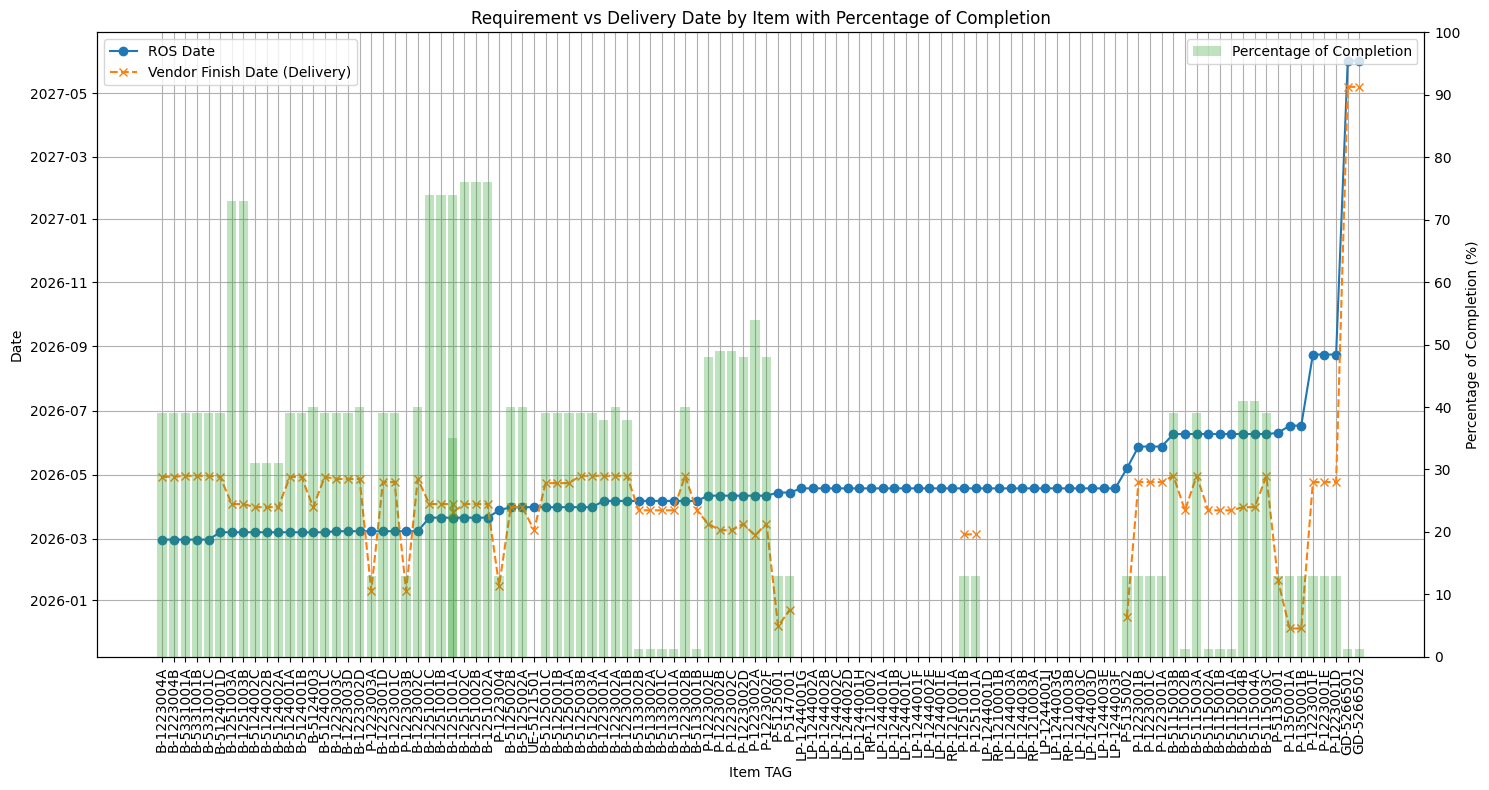

In [30]:
import matplotlib.pyplot as plt

# Certifique-se de que as datas estão no formato datetime
df_mapa['3RW ROS Date'] = pd.to_datetime(df_mapa['3RW ROS Date'], errors='coerce')
df_mapa['Finish'] = pd.to_datetime(df_mapa['Finish'], errors='coerce')

# Filtra df_mapa para incluir apenas as linhas onde TAG não é vazio
df_mapa = df_mapa[df_mapa['TAG'].notna() & (df_mapa['TAG'] != '')]

# Ordena o DataFrame por '3RW ROS Date' para melhor visualização
df_mapa = df_mapa.sort_values(by='3RW ROS Date')

# Define 'item_tag' como índice para facilitar o plot
df_mapa = df_mapa.set_index('item_tag')

# Converte "Percentage of Completion" para float (removendo % e tratando vírgula)
def pct_to_float(x):
    if isinstance(x, str):
        x = x.replace('%', '').replace(',', '.').strip()
        try:
            return float(x)
        except ValueError:
            return None
    return x

df_mapa['Percentage of Completion'] = df_mapa['Percentage of Completion'].apply(pct_to_float)

# Plotando os dados
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.plot(df_mapa.index, df_mapa['3RW ROS Date'], marker='o', linestyle='-', label='ROS Date')
ax1.plot(df_mapa.index, df_mapa['Finish'], marker='x', linestyle='--', label='Vendor Finish Date (Delivery)')
ax1.set_xlabel('Item TAG')
ax1.set_ylabel('Date')
ax1.tick_params(axis='x', rotation=90)
ax1.legend(loc='upper left')
ax1.grid(True)

# Segundo eixo Y para Percentage of Completion com grafico de barras e escala de 0% a 100%:
ax2 = ax1.twinx()
ax2.bar(df_mapa.index, df_mapa['Percentage of Completion'], color='tab:green', alpha=0.3, label='Percentage of Completion')
ax2.set_ylim(0, 100)  # Definindo o limite do eixo Y para 0 a 100%
ax2.set_yticks(np.arange(0, 101, 10))  # Definindo os ticks do eixo Y de 10 em 10
ax2.set_ylabel('Percentage of Completion (%)')
ax2.legend(loc='upper right')

plt.title('Requirement vs Delivery Date by Item with Percentage of Completion')
plt.tight_layout()
plt.show()

# Reset index
df_mapa = df_mapa.reset_index()